# Zadanie 5

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 7 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1 pkt]
- Wnioski [1 pkt]


In [3]:
import numpy as np
import gym
import matplotlib.pyplot as plt 
MAX_EPISODES = 1000
MAX_TRAIN_STEPS = 1000000

In [4]:
class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.1,
        discount: float = 0.9,
        epsilon: float = 0.1,
    ):
        # zaimplementowac tablice Q
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon

        self.q_table = np.random.uniform(
            low=-2, high=0, size=(observation_space, action_space)
        )

        self.episodes_cumulative_reward = []
        self.steps_per_episode = 0
        self.avg_rewards = []
        self.avg_reward_per_episode = 0
        self.avg_penalties_per_episode = 0

    def __call__(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        """Return Q-value of given state and action."""
        return self.q_table[state, action]

    def update(self, state: np.ndarray, action: np.ndarray, new_q: float) -> None:
        """Update Q-value of given state and action."""
        self.q_table[state, action] = new_q

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        return np.argmax(self.q_table[state, :])

    def get_max_q(self, state: np.ndarray) -> np.ndarray:
        """Return maximum Q-value for a given state."""
        return np.max(self.q_table[state, :])

    def train(self, env, train_episodes):
        penalties = 0
        train_steps = 0
        for episode in range(train_episodes):
            state, _ = env.reset()
            done = False
            truncated = False
            cumulative_reward = 0

            while not done and not truncated:
                if np.random.random() < self.epsilon:
                    action = env.action_space.sample()
                else:
                    action = self.get_best_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                max_future_q = self.get_max_q(next_state)
                current_q = self(state, action)
                new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (
                    reward + self.discount * max_future_q
                )
                self.update(state, action, new_q)
                state = next_state

                if reward == -10:
                    penalties += 1
                cumulative_reward += reward
                train_steps += 1

            self.avg_reward_per_episode += cumulative_reward
            self.avg_rewards.append(cumulative_reward / train_steps)
            self.episodes_cumulative_reward.append(cumulative_reward)
        self.steps_per_episode = train_steps / train_episodes
        self.avg_reward_per_episode = self.avg_reward_per_episode / train_episodes
        self.avg_penalties_per_episode = penalties / train_episodes

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        return f"""
        Q-learning solver
        
        observation_space: {self.observation_space},
        action_space: {self.action_space},
        learning_rate: {self.learning_rate},
        discount: {self.discount},
        epsilon: {self.epsilon}"""

    def __str__(self):
        # do wizualizacji
        return self.__repr__()

# Eksperymenty

## Discount

W poniższych eksperymentach badany jest parametr discount. Wartości pozostałych parametrów pozostają stałe:
* learning_rate = 0.1
* episodes = 200
* epsilon = 0.1


Im większa wartosć discount, tym większa wagę ma nagroda osiągana na końcu scieżki. 

/home/jmacuga/.local/lib/python3.10/site-packages/gym/envs/registration.py:623: UserWarning: WARN: The environment is being initialised with mode (ascii) that is not in the possible render_modes (['human', 'ansi', 'rgb_array']).
  logger.warn(


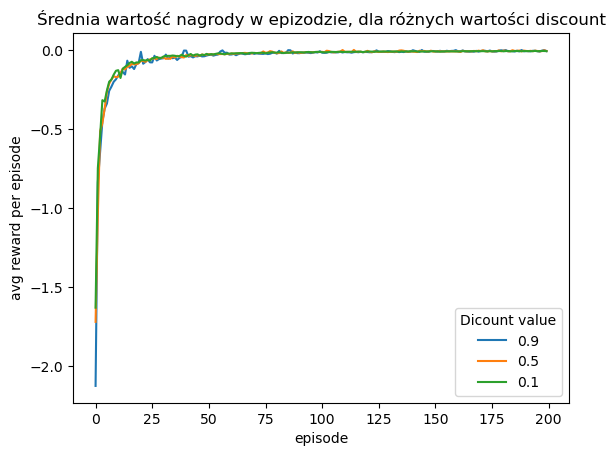

In [6]:
env = gym.make("Taxi-v3", render_mode="ascii")
discount_values = [0.9, 0.5, 0.1]

_, ax = plt.subplots()

episodes = 200

for discount in discount_values:
    q_solver = QLearningSolver(
        env.observation_space.n, env.action_space.n, discount=discount
    )
    q_solver.train(env, episodes)
    ax.plot(list(range(episodes)), q_solver.avg_rewards)

env.close()

ax.set(
    xlabel="episode",
    ylabel="avg reward per episode")
_ = ax.legend(
    discount_values,
    loc="lower right",
    title="Dicount value")
ax.set_title(f"Średnia wartość nagrody w epizodzie, dla różnych wartości discount")

plt.show()

In [ ]:
env = gym.make("Taxi-v3", render_mode="ascii")

discount_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


episodes = 1000
rewards = []
steps_per_episode_arr = []
avg_rewards_arr = []
penalties_count = []
for discount in discount_values:
    iter_count = 10
    disc_steps = 0
    disc_rewards = 0
    disc_penalties = 0
    for i in range(iter_count):
        q_solver = QLearningSolver(
            env.observation_space.n, env.action_space.n, discount=discount
        )
        q_solver.train(env, episodes)
        disc_steps += q_solver.steps_per_episode
        disc_rewards += q_solver.avg_reward_per_episode
        disc_penalties += q_solver.avg_penalties_per_episode
    steps_per_episode_arr.append(disc_steps / iter_count)
    avg_rewards_arr.append(disc_rewards / iter_count)
    penalties_count.append(disc_penalties / iter_count)

env.close()


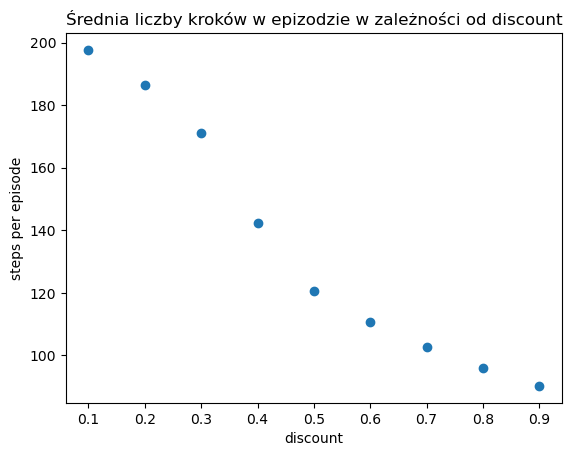

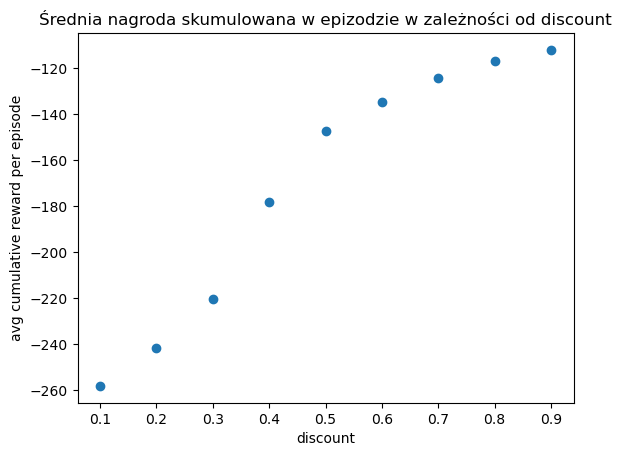

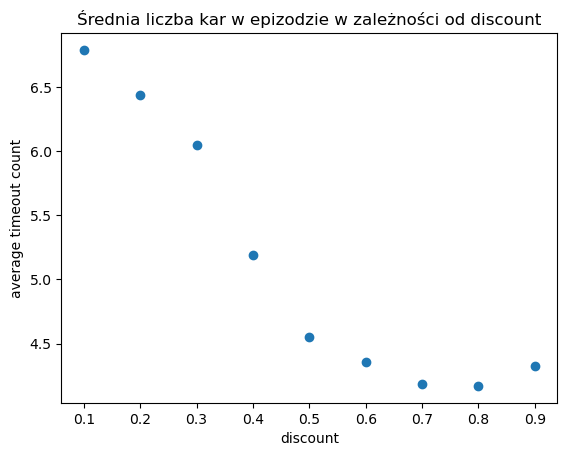

In [17]:
_, ax = plt.subplots()
_, ax1 = plt.subplots()
_, ax2 = plt.subplots()

ax.scatter(discount_values, steps_per_episode_arr)
ax.set(
    xlabel="discount",
    ylabel="steps per episode",
)

ax.set_title(f"Średnia liczby kroków w epizodzie w zależności od discount")


ax1.scatter(discount_values, avg_rewards_arr)
ax1.set(
    xlabel="discount",
    ylabel="avg cumulative reward per episode",
)

ax1.set_title(f"Średnia nagroda skumulowana w epizodzie w zależności od discount")


ax2.scatter(discount_values, penalties_count)
ax2.set(
    xlabel="discount",
    ylabel="average timeout count",
)

ax2.set_title(f"Średnia liczba kar w epizodzie w zależności od discount")
plt.show()

### Obserwacje i wnioski

Parametr discount zmniejsza średnią liczbę króków w epizodzie, potrzebną do osiągnięcia celu. Oznacza to, że uczenie algorytmu jest szybsze.

Wraz ze wzrostem discount rośnie taże średnia wartość skumulowanej nagrody na epizod. Uczenie jest skuteczniejsze, algorytm cześciej osiąga cel.

Na powyższych wykresach widoczne jest przegięcie w okolicy discount = 0.5. Dla wartości discount < 0.5, końcowa wartość nagrody ma mniejszą wagę niż nagroda w chwili obecnej, przez co algorytm nie zbiega do rozwiązania.  

## Learning rate

Wartości pozostałych parametrów: 
* discount = 0.9
* episodes = 200
* epsilon = 0.1

In [19]:
env = gym.make("Taxi-v3", render_mode="ascii")

learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


episodes = 200
rewards = []
steps_per_episode_arr = []
avg_rewards_arr = []
penalties_count = []
for lr in learning_rates:
    iter_count = 10
    lr_steps = 0
    lr_rewards = 0
    lr_penalties = 0
    for i in range(iter_count):
        q_solver = QLearningSolver(
            env.observation_space.n, env.action_space.n, learning_rate=lr
        )
        q_solver.train(env, episodes)
        lr_steps += q_solver.steps_per_episode
        lr_rewards += q_solver.avg_reward_per_episode
        lr_penalties += q_solver.avg_penalties_per_episode
    steps_per_episode_arr.append(lr_steps / iter_count)
    avg_rewards_arr.append(lr_rewards / iter_count)
    penalties_count.append(lr_penalties / iter_count)

env.close()

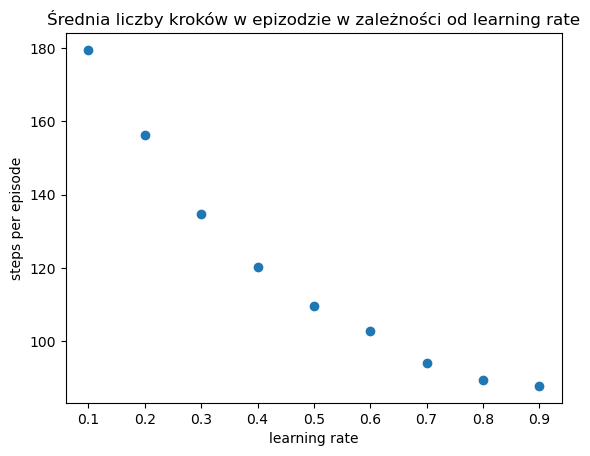

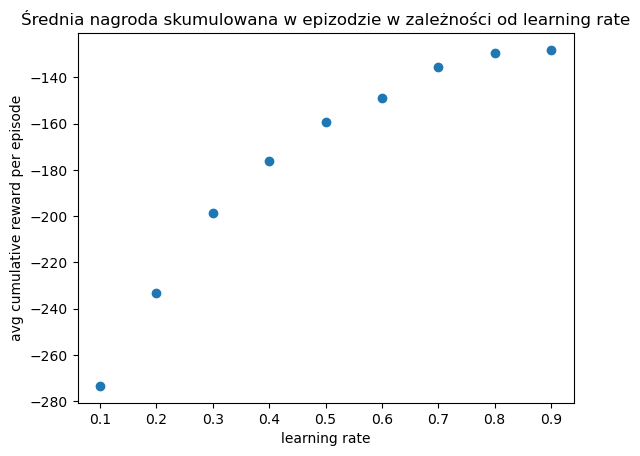

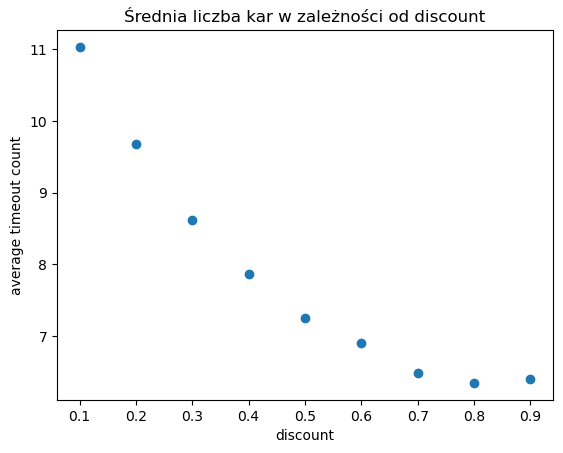

In [20]:
_, ax = plt.subplots()
_, ax1 = plt.subplots()
_, ax2 = plt.subplots()

ax.scatter(discount_values, steps_per_episode_arr)
ax.set(
    xlabel="learning rate",
    ylabel="steps per episode",
)

ax.set_title(f"Średnia liczby kroków w epizodzie w zależności od learning rate")


ax1.scatter(discount_values, avg_rewards_arr)
ax1.set(
    xlabel="learning rate",
    ylabel="avg cumulative reward per episode",
)

ax1.set_title(f"Średnia nagroda skumulowana w epizodzie w zależności od learning rate")


ax2.scatter(discount_values, penalties_count)
ax2.set(
    xlabel="discount",
    ylabel="average timeout count",
)

ax2.set_title(f"Średnia liczba kar w zależności od discount")
plt.show()

### Obserwacje i wnioski

Zwiększanie parametru learning rate powoduje przyspieszenie uczenia i zwiększenie skuteczności uczenia algorytmu.

## Epsilon

* learning_rate = 0.1
* discount = 0.9 

In [9]:
env = gym.make("Taxi-v3", render_mode="ascii")

epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


episodes = 200
rewards = []
steps_per_episode_arr = []
avg_rewards_arr = []
penalties_count = []
for eps in epsilon_values:
    iter_count = 10
    eps_steps = 0
    eps_rewards = 0
    eps_penalties = 0
    for i in range(iter_count):
        q_solver = QLearningSolver(
            env.observation_space.n, env.action_space.n, epsilon=eps
        )
        q_solver.train(env, episodes)
        eps_steps += q_solver.steps_per_episode
        eps_rewards += q_solver.avg_reward_per_episode
        eps_penalties += q_solver.avg_penalties_per_episode
    steps_per_episode_arr.append(eps_steps / iter_count)
    avg_rewards_arr.append(eps_rewards / iter_count)
    penalties_count.append(eps_penalties / iter_count)

env.close()

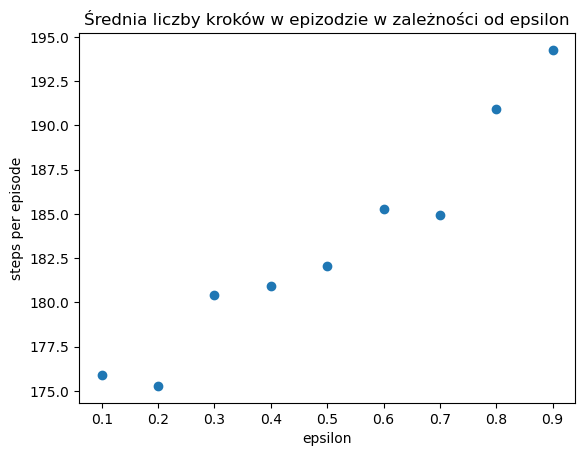

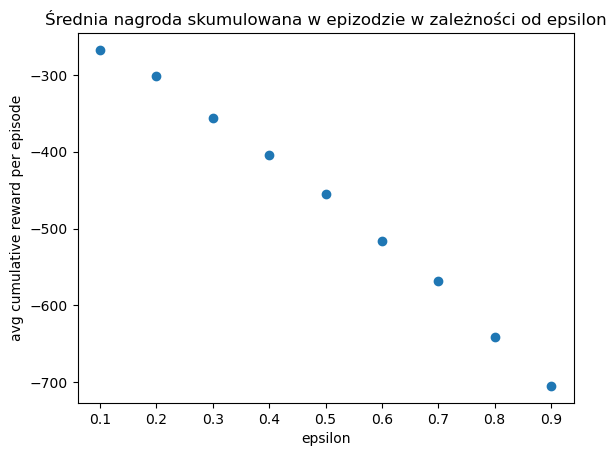

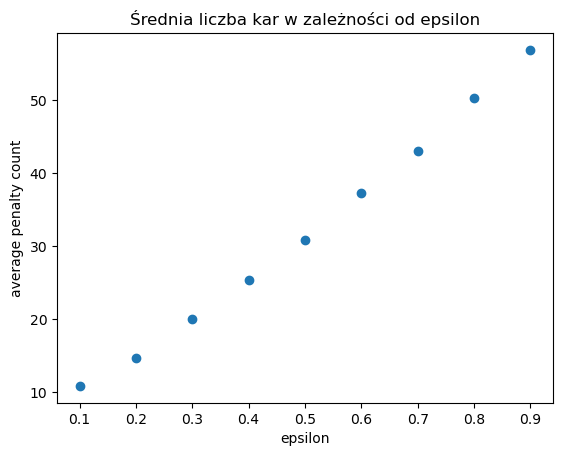

In [11]:
_, ax = plt.subplots()
_, ax1 = plt.subplots()
_, ax2 = plt.subplots()

ax.scatter(epsilon_values, steps_per_episode_arr)
ax.set(
    xlabel="epsilon",
    ylabel="steps per episode",
)

ax.set_title(f"Średnia liczby kroków w epizodzie w zależności od epsilon")


ax1.scatter(epsilon_values, avg_rewards_arr)
ax1.set(
    xlabel="epsilon",
    ylabel="avg cumulative reward per episode",
)

ax1.set_title(f"Średnia nagroda skumulowana w epizodzie w zależności od epsilon")


ax2.scatter(epsilon_values, penalties_count)
ax2.set(
    xlabel="epsilon",
    ylabel="average penalty count",
)

ax2.set_title(f"Średnia liczba kar w zależności od epsilon")
plt.show()

# Wizualizacja gym

In [ ]:
episodes = 1000
env = gym.make("Taxi-v3", render_mode="ascii")
q_solver = QLearningSolver(env.observation_space.n, env.action_space.n)
q_solver.train(env, episodes)
env.close()

env = gym.make("Taxi-v3", render_mode="human")

state, _ = env.reset()
print("taxi")
done = False
truncated = False
while not done and not truncated:
    if np.random.random() > q_solver.epsilon:
        action = q_solver.get_best_action(state)
    else:
        action = np.random.randint(0, env.action_space.n)
    next_state, reward, done, truncated, info = env.step(action)
    env.render()
    state = next_state
    if reward == 20:
        print("reached the goal!")
        break
env.close()

/home/jmacuga/.local/lib/python3.10/site-packages/gym/envs/registration.py:623: UserWarning: WARN: The environment is being initialised with mode (ascii) that is not in the possible render_modes (['human', 'ansi', 'rgb_array']).
  logger.warn(


taxi
3
361 -1
3
361 -1
3
361 -1
5
361 -10
3
361 -1
3
361 -1
0
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1
3
461 -1


: 

# Wnioski